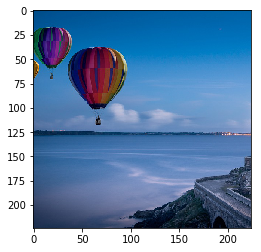

150528
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
act

In [2]:
import keras
from keras.layers import Flatten,Dense
from keras.preprocessing.image import array_to_img,load_img,img_to_array
from keras.models import Model
from keras.applications import imagenet_utils,vgg16,resnet50

import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline


img_path='balloon-1.jpg'
img=load_img(img_path)
plt.imshow(img)


def preprocess_img(img_path):
    
    img=load_img(img_path)
    width,height=img.size
    
    im_height_n=224

    im_width_n=int(width*im_height_n/height)
    desired_width, desired_height = 224, 224
    
    img = img.resize((im_width_n, im_height_n))
    #img=img_to_array(img)
    #img = array_to_img(img, scale=False)
    #plt.imshow(img)
    #plt.show()
    if im_width_n < desired_width:
        desired_width = im_width_n
    start_x = np.maximum(0, int(im_width_n-desired_width)/2)
    start_y= np.maximum(0, int(im_height_n-desired_height)/2)

    img = img.crop((start_x, start_y, start_x+desired_width, start_y+desired_height))
    #plt.imshow(img)
    #plt.show()
    img_crop= img.resize((224, 224))
    plt.imshow(img)
    plt.show()

    img = img_to_array(img)
    
    print(img.size)
    img=np.expand_dims(img,axis=0)  #add one dimension to get 1,width,height for batch size
    img=resnet50.preprocess_input(img)
    return img,img_crop

input_img,img_crop=preprocess_img(img_path)


model_resnet50=resnet50.ResNet50(input_shape=(224,224,3),include_top=True,weights='imagenet')

result=model_resnet50.predict(input_img)
result_arg=result.argmax()   #max arg index
result_decoded=imagenet_utils.decode_predictions(result,top=10)

#weight 

layer_fc1000=model_resnet50.get_layer('fc1000')

weight_fc1000=layer_fc1000.get_weights()[0]

model_resnet50.summary()

resnet50_last_conv=model_resnet50.get_layer('activation_49')
model_resnet50_last_conv=Model(inputs=model_resnet50.input,outputs=resnet50_last_conv.output)

layer_2048=model_resnet50_last_conv.predict(input_img)[0]  #activation 512 filters

#layer_2048

In [5]:
imagenet_utils.decode_predictions(result,top=10)[0][0]

('n02782093', 'balloon', 0.97342414)

In [6]:
print(result.argmax())

417


In [7]:
W=weight_fc1000[:,result_arg]   #2048

In [8]:
filter_after_dot=layer_2048.dot(W)

In [9]:
filter_after_dot

array([[  5.9723244 ,   6.457431  ,   0.31639707,   0.7385879 ,
          0.9291412 ,   0.9121053 ,   1.1904682 ],
       [ 37.408054  ,  50.050766  ,  41.934544  ,  18.348433  ,
          1.0519576 ,   0.8453303 ,   1.6570505 ],
       [ 38.53164   ,  82.63868   , 103.686905  ,  56.572975  ,
          2.2131827 ,   0.857116  ,   1.7730516 ],
       [  9.886978  ,  59.570393  ,  90.0287    ,  55.562424  ,
          2.3091848 ,   2.16246   ,   2.8101466 ],
       [  3.2196763 ,  17.78718   ,  28.804283  ,  11.684493  ,
         -0.8989068 ,  -1.0005524 ,  -0.56124127],
       [  2.6365235 ,   4.2905264 ,   5.9691887 ,   5.181683  ,
          1.8133245 ,  -3.6577718 , -10.185888  ],
       [  0.30273855,   2.2532988 ,   4.849828  ,   8.068329  ,
          4.0669937 ,  -6.92905   ,  -8.574307  ]], dtype=float32)

In [10]:
import scipy

img_filter_zoomout=scipy.ndimage.zoom(filter_after_dot,(32,32),order=1)

Text(0.5,1,"('n02782093', 'balloon', 0.97342414)")

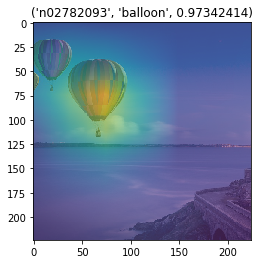

In [13]:
plt.imshow(img_crop,alpha=0.8)
plt.imshow(img_filter_zoomout,alpha=0.5)
plt.title(imagenet_utils.decode_predictions(result,top=10)[0][0])